# Solving Differential equations in Julia

In this notebook I will go over some of the basics of solving ordinary differential equations (ODEs) numerically using ```julia```. I will demonstrate how to integrate differential equations using two approaches:

1. Implement a solution method, like the [Euler method](https://en.wikipedia.org/wiki/Euler_method), in a DIY (Do It Yourself!) way.

2. Solve using the functions in the julia package [```DifferentialEquations.jl```](http://docs.juliadiffeq.org/latest/).


To run this notebook you will need the following packages:

- To plot the results: ```Plots.jl``` and```PyPlot.jl```. Also ```LaTeXStrings.jl``` to be able to use LaTeX in the labels of the figures. 
- Labelled arrays (which  I explain later) ```LabelledArrays```.
- To use the differential equations functions ```DiffEqCallbacks.jl``` and ```DifferentialEquations.jl```



In [1]:
using Plots; pyplot();
using LaTeXStrings;
using Printf;

The examples I will use to illustrate the different approaches are

1. ***Particle moving in a anhamornic potential***
2. ***Lotka-Volterra equations***
3. ***Langevin equation of a particle in a anharmonic potential***

# Overview of the 2 methods

I will focus on ODEs systems of first degree, which have normally the form $\frac{d}{dt}X(t) = f(X(t),P,t)$, where $X(t) = \left( X_1(t),X_2(t),...,X_N(t)\right)^\mathsf{T}$ is the vector containing the $N$ independent variables, $P=\left( P_1,P_2,...,P_M\right)^\mathsf{T}$ is a vector containing all $M$ parameters the problem depends on, and $t$ is time. $f(X(t),P,t)$ is an $N$-dimensional vector function that gives the evoliution of the components of $X$, $\frac{d}{dt}X_i(t) = f_i(X(t),P,t)$. This kind of system is pretty general, because even if we have a system of equations of higher degree we can alaways reduce it to first degree.

### Solution with DIY solver

In this section I consider the [Euler method](https://en.wikipedia.org/wiki/Euler_method) for its simplicity, the same philosophy can be applied to other methods.

The Euler method consists in discretizing the time variable in small intervals 

```pseudocode
x_[i+1] = x_[i] + f(x_[i]),P,t_[i]) * (t_[i+1]-t_[i])
```

### Solution with ```DifferentialEquations.jl```

# Particle in an an-harmonic potential potential

Consider the Hamiltonian of a particle of unit mass moving in a potential $V(x) =  \left|x\right|^{\alpha}$, which is described by the Hamiltonian $H(x,p) = \frac{1}{2}p^2 + \left|x\right|^{\alpha}$ with $\alpha > 0$. The equations of motion are
$$
\begin{split}
\dot{x} &=\frac{\partial H}{\partial p} &= p
\\
\dot{p} &=- \frac{\partial H}{\partial x} &= -\alpha \left|x\right|^{\alpha-1} sign(x)
\end{split}
$$

Import the needed packages

In [2]:
using DiffEqCallbacks;
using DifferentialEquations;
using LabelledArrays;

```f(du,u,P,t)``` function

In [3]:
function f!(du,u,P,t)
    du[1] = u[2];
    du[2] = -P.α .* abs(u[1])^(P.α - 1.) .* sign(u[1])
end;

function f(u,P,t)
    return [u[2],-P.α .* abs(u[1])^(P.α - 1.).* sign(u[1])] 
end;

See how the derivative (f) of the phase-space vector look

In [4]:
x = collect(LinRange(-.7,.7,20));
p = collect(LinRange(-.7,.7,20));

x_mesh = [x[ii] for ii in eachindex(x) for jj in eachindex(p) ];
p_mesh = [p[jj] for ii in eachindex(x) for jj in eachindex(p) ];

P = LVector(α=1.1);

du = [f([x_mesh[ii],p_mesh[ii]],P,0) for ii in eachindex(x_mesh)]
U = [du[ii][1] for ii in eachindex(du)];
V = [du[ii][2] for ii in eachindex(du)];
Norm = sqrt.(U.^2+V.^2);

U = U./Norm;
V = V./Norm;

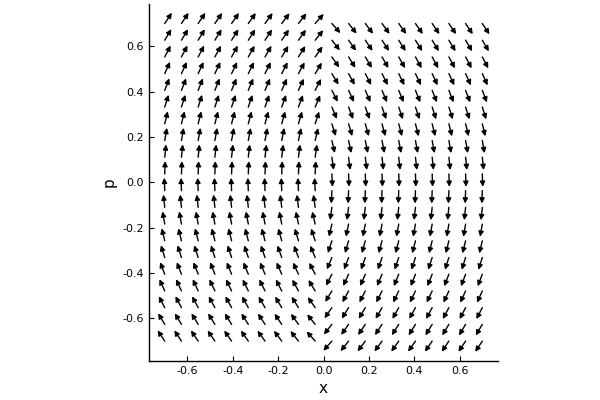

In [5]:
scale = .05
plot(
    grid=false
    ,xlabel = "x"
    ,ylabel = "p"
)
quiver!(
    x_mesh,p_mesh,gradient = scale.*(U,V),aspectratio=1.
    ,color = :black
)

Different initial conditions

In [6]:
u0 = [[2. * ii^(1. / P.α),0.] for ii in 0.01:0.02:0.1];

Time Span

In [7]:
T_Final = 5.
tspan = (0.0,T_Final);

ODE problems

In [8]:
problems = [ODEProblem(f!,u0[ii],tspan,P) for ii in eachindex(u0)];

The Solutions

In [9]:
dtmax = 0.005
sols = solve.(problems,dtmax=dtmax);

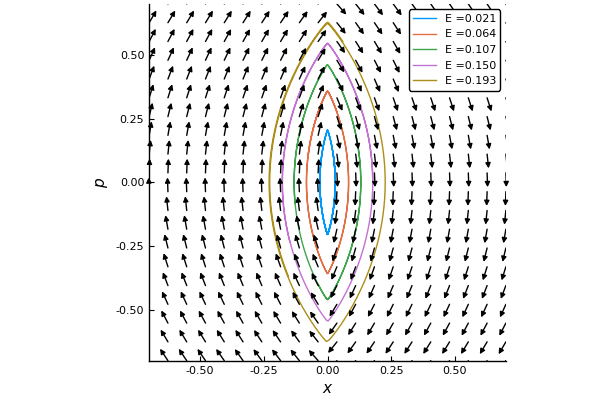

In [10]:
plotPhase = plot(
    grid = false
    ,legend = true
    ,xlim= (-0.7,0.7)
    ,ylim= (-0.7,0.7)
    ,xlabel = latexstring("x")
    ,ylabel = latexstring("p")
    ,aspectratio=1
)

plotΔt = 0.01;
foreach(sol->
    plot!(
        [sol(t)[1] for t in 1:plotΔt:T_Final],[sol(t)[2] for t in 1:plotΔt:T_Final]
        ,label=string("E =",@sprintf("%.3f", sol(0)[1]^(P.α)))
    )
,sols);

quiver!(
    x_mesh,p_mesh,gradient = scale.*(U,V),aspectratio=1.
    ,color = :black
)

plotPhase

# Lotka-Volterra model

#### Solution with ```DifferentialEquations.jl```

```f(du,u,P,t)``` function

In [78]:
function f_LV!(dQ,Q,P,t)
    dQ[1] = Q[1] * (P.α - P.β * Q[2]);
    dQ[2] = -Q[2] * (P.γ - P.δ * Q[1]);
end;

function f_LV(Q,P,t)
    return [
            Q[1] * (P.α - P.β * Q[2]),
            -Q[2] * (P.γ - P.δ * Q[1])
    ];
end;

In [181]:
x = collect(LinRange(0,8,15))
y = copy(x)

X = [x[ii] for ii in eachindex(x) for jj in eachindex(y) ]
Y = [y[jj] for ii in eachindex(x) for jj in eachindex(y) ]

P_LV = LVector(α =4. , β=1. , γ = 4. , δ = 1.);

U = zeros(length(X));
V = copy(U);

for ii in eachindex(X)
    U[ii], V[ii] = f_LV([X[ii],Y[ii]],P_LV,0);
    #Normalize the arrows to 1.
    Norm = sqrt(U[ii]^2+V[ii]^2);
    U[ii] = U[ii]/Norm;
    V[ii] = V[ii]/Norm;
end

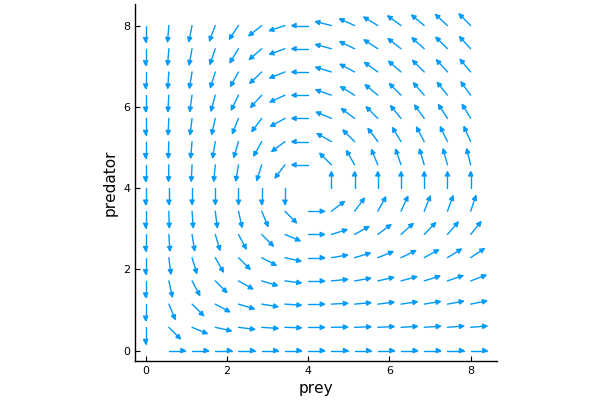

In [182]:
scale = 0.4

plotLotka = plot(
    grid = false
    ,legend = false
    ,xlabel = "prey"
    ,ylabel = "predator"
)


quiver!(X,Y,gradient=scale.*(U,V),aspectratio=1)

In [183]:
X_eq, Y_eq = P_LV.α/P_LV.β, P_LV.γ/P_LV.δ;

trajectories_LV =  5;
width = 0.5

u0_LV = [[X_eq+width*ii,Y_eq+width*ii] for ii in 1:trajectories_LV]

5-element Array{Array{Float64,1},1}:
 [4.5, 4.5]
 [5.0, 5.0]
 [5.5, 5.5]
 [6.0, 6.0]
 [6.5, 6.5]

In [184]:
T_Final_LV = 10.
tspan_LV = (0.0,T_Final_LV);

ODE problems

In [185]:
problems_LV = [ODEProblem(f_LV!,u0_LV[ii],tspan_LV,P_LV) for ii in eachindex(u0_LV)];

The Solutions

In [186]:
sols_LV = solve.(problems_LV);

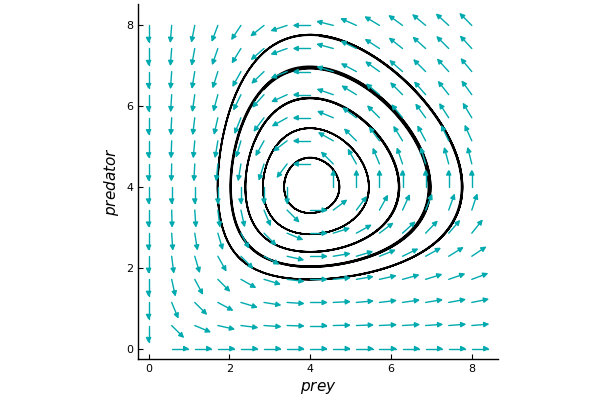

In [187]:
plotPhase_LV = plot(
    grid = false
    ,legend = false
    ,xlabel = latexstring("prey")
    ,ylabel = latexstring("predator")
)

plotΔt_LV = 0.01;
foreach(sol->
    plot!(
        [sol(t)[1] for t in 1:plotΔt:T_Final_LV],[sol(t)[2] for t in 1:plotΔt_LV:T_Final_LV]
        ,color=:black
    )
,sols_LV);

quiver!(X,Y,gradient=scale.*(U,V),aspectratio=1)

plotPhase_LV

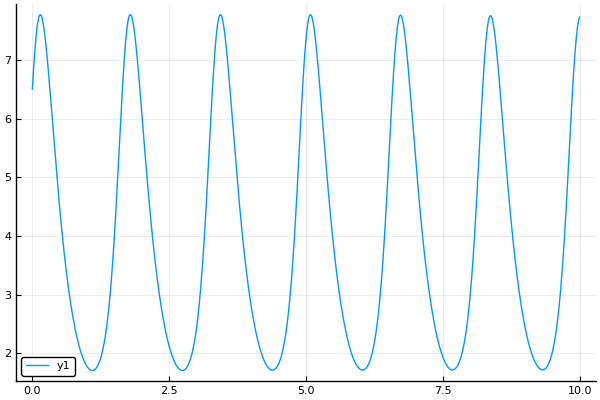

In [207]:
tt = 0:0.01:T_Final_LV
plot(
    t,[sols_LV[end](t)[2] for t in tt]
    )

In [201]:
sols_LV[1].(t)

1001-element Array{Array{Float64,1},1}:
 [4.5, 4.5]        
 [4.47706, 4.52204]
 [4.45327, 4.54313]
 [4.4287, 4.56321] 
 [4.40341, 4.58224]
 [4.37745, 4.60017]
 [4.35089, 4.61695]
 [4.32378, 4.63255]
 [4.29621, 4.64694]
 [4.26822, 4.66007]
 [4.23988, 4.67193]
 [4.21126, 4.68248]
 [4.18242, 4.69171]
 ⋮                 
 [3.41988, 4.33622]
 [3.40886, 4.31088]
 [3.39875, 4.28523]
 [3.38954, 4.2593] 
 [3.38126, 4.23316]
 [3.37388, 4.20683]
 [3.36741, 4.18038]
 [3.36184, 4.15383]
 [3.35717, 4.12725]
 [3.35339, 4.10067]
 [3.35049, 4.07414]
 [3.34846, 4.04771]